In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import LabelEncoder
import random

In [3]:
# Import dataset
with open('intents.json', 'r') as f:
    intents = json.load(f)['intents']


In [4]:
# Menggabungkan semua patterns dan tags
patterns = []
tags = []
responses = {}
for intent in intents:
    for pattern in intent['patterns']:
        patterns.append(pattern)
        tags.append(intent['tag'])
    responses[intent['tag']] = intent['responses']


In [5]:
# Create DataFrame
data = pd.DataFrame({"inputs": patterns, "tags": tags})



In [6]:
data

,inputs,tags
0,Halo,salam
1,Hai,salam
2,Ada yang bisa saya bantu?,salam
3,Hai apa kabar,salam
4,Halo,salam
...,...,...
339,Bagaimana cara mengatasi stigmatisasi terkait ...,fakta-78
340,Apakah terapi online efektif untuk masalah kes...,fakta-79
341,Bagaimana cara merawat diri sendiri saat menga...,fakta-80
342,Apa peran olahraga dalam menjaga kesehatan men...,fakta-81


In [15]:
# Menghilangkan tanda baca
data['inputs'] = data['inputs'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))

In [9]:
# Tokenize the inputs
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
sequences = tokenizer.texts_to_sequences(data['inputs'])
x_train = pad_sequences(sequences)


In [10]:
# Encode the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

input_shape = x_train.shape[1]
print(input_shape)


17


In [11]:
# Define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words: ", vocabulary)
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words:  332
output length:  130


In [12]:
# Membuat model
i = Input(shape=(input_shape,))
x = Embedding(vocabulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)


In [13]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [18]:
# Training model
train = model.fit(x_train, y_train, epochs=200)


Epoch 1/200
11/11 [==============================] - 0s 11ms/step - loss: 0.5919 - accuracy: 0.9157
Epoch 2/200
11/11 [==============================] - 0s 10ms/step - loss: 0.5843 - accuracy: 0.9186
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 0.5784 - accuracy: 0.9215
Epoch 4/200
11/11 [==============================] - 0s 12ms/step - loss: 0.5771 - accuracy: 0.9186
Epoch 5/200
11/11 [==============================] - 0s 10ms/step - loss: 0.5730 - accuracy: 0.9215
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 0.5677 - accuracy: 0.9099
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 0.5640 - accuracy: 0.9244
Epoch 8/200
11/11 [==============================] - 0s 8ms/step - loss: 0.5552 - accuracy: 0.9273
Epoch 9/200
11/11 [==============================] - 0s 10ms/step - loss: 0.5540 - accuracy: 0.9099
Epoch 10/200
11/11 [==============================] - 0s 9ms/step - loss: 0.5455 - accuracy: 0.9157
Epo

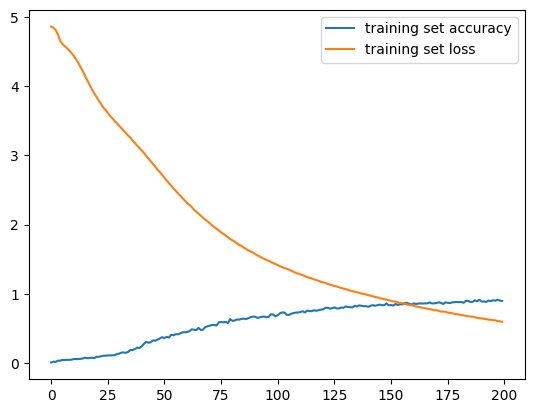

In [16]:
# Plotting model accuracy
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.legend()
plt.show()

In [17]:
# Chatbot interaction
while True:
    texts_p = []
    prediction_input = input('You: ')

    # Menghapus punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    # Tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Mendapatkan output dari model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Mencari tag yang benar dan prediksi
    response_tag = le.inverse_transform([output])[0]
    print("chatbot:", random.choice(responses[response_tag]))
    if response_tag == "selamat tinggal":
        break

You: hi
1/1 [==============================] - 0s 479ms/step
chatbot: Halo. Senang melihatmu kembali. Ada yang bisa saya bantu?
You: saya sedang depresi
1/1 [==============================] - 0s 22ms/step
chatbot: Bicarakan apa yang sedang terjadi. Kamu akan baik-baik saja
You: ya saya lumayan baik baik saja
1/1 [==============================] - 0s 24ms/step
chatbot: Oh saya melihat. Itu bagus.
You: apa yang dimasud dengan depresi
1/1 [==============================] - 0s 35ms/step
chatbot: Terapi adalah bentuk pengobatan yang bertujuan untuk membantu menyelesaikan masalah mental atau emosional. Ini berguna bagi mereka yang memiliki kondisi kesehatan mental atau bahkan tantangan kehidupan sehari-hari.


KeyboardInterrupt: Interrupted by user